In [ ]:
!pip install khmerspell tensorflow==2.17.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 601.4/601.4 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 80.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.0/18.0 MB 91.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.9/294.9 kB 24.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 98.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 5.29.5
    Uninstalling protobuf-5.29.5:
      Successfully uninstalled protobuf-5.29.5
  Attempting uninstall: numpy
    Found existing installation: numpy 2.0.2
    Uninstalling numpy-2.0.2:
      Successfully uninstalled numpy-2.0.2
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.19.0
    Uninstalling tensorboard-2.19.0:
      Successfully uninstalled tensorboard-2.19.0
  Attempting uninstall: ml-dtypes
    Fo

In [ ]:
"""
IMPORTS
"""

from khmerspell import khnormal
import re
import numpy as np
import os

import tensorflow as tf

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import (
    Input, Dense, Embedding, LayerNormalization,
    MultiHeadAttention, Dropout, GlobalAveragePooling1D
)
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow.keras.backend as K
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, SimpleRNN, Dense, Embedding, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.initializers import GlorotUniform
from tensorflow.keras.optimizers import Adam

In [ ]:
"""
NORMALIZE AND CLEAN TEXT
"""

# Preprocessing functions (as provided)
def normalize_khmer(text):
    """Properly handle combined characters"""
    return khnormal(text)

def clean_text(text, is_khmer=False):
    """Universal cleaner with debug prints"""
    text = str(text).strip()
    if is_khmer:
        text = re.sub(r'[^\u1780-\u17FF]', '', text)
        text = normalize_khmer(text)
    else:
        text = re.sub(r'[^a-z]', '', text.lower())
    return text

print(clean_text(" S'rolanH! "))  # Should output "srolanh"
print(clean_text("ស្រ្ដី", True))

srolanh
ស្ត្រី


In [ ]:
def load_data(filename):
    pairs = []
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f:
            if ':' in line:
                khmer_part, eng_part = line.strip().split(':', 1)
                khmer_clean = clean_text(khmer_part, True)
                for eng in eng_part.split(','):
                    eng_clean = clean_text(eng.strip())
                    if eng_clean and khmer_clean:
                        pairs.append((eng_clean, khmer_clean))
    return pairs

dataset = load_data('eng_khm_data.txt')
print(f"Loaded {len(dataset)} pairs")
print("Sample:", dataset[:3])

Loaded 28569 pairs
Sample: [('brodae', 'ប្រដែ'), ('aasangkheyy', 'អសង្ខៃយ'), ('chhatkophey', 'ឆាតកភ័យ')]


In [ ]:
# Control tokens
start_token_char = '\t'
end_token_char = '\n'

# English tokenizer
eng_tokenizer = Tokenizer(char_level=True, filters='', oov_token='<unk>')
eng_tokenizer.fit_on_texts([eng for eng, _ in dataset])
print(f"English tokenizer word_index (sample): {list(eng_tokenizer.word_index.items())[:10]}")

# Khmer tokenizer with explicit start/end
khm_tokenizer = Tokenizer(char_level=True, filters='', oov_token='<unk>')
khm_tokenizer.fit_on_texts([start_token_char, end_token_char] + [khm for _, khm in dataset])
print(f"Khmer tokenizer word_index (sample): {list(khm_tokenizer.word_index.items())[:10]}")

start_token = khm_tokenizer.word_index[start_token_char]
end_token   = khm_tokenizer.word_index[end_token_char]
print(f"Start token ID: {start_token}, End token ID: {end_token}")

# Max lengths
max_eng_len = max(len(eng) for eng, _ in dataset)
max_khm_len = max(len(khm) for _, khm in dataset)
print(f"Max English length: {max_eng_len}, Max Khmer length: {max_khm_len}")

# Encode sequences
encoder_inputs, decoder_inputs, decoder_targets = [], [], []

for i, (eng, khm) in enumerate(dataset):
    enc_seq = eng_tokenizer.texts_to_sequences([eng])[0]
    khm_seq = khm_tokenizer.texts_to_sequences([khm])[0]

    encoder_inputs.append(enc_seq)
    decoder_inputs.append([start_token] + khm_seq)
    decoder_targets.append(khm_seq + [end_token])

    if i < 3:  # Print first 3 examples
        print(f"\nSample {i}:")
        print(f"English: {eng}")
        print(f"Khmer: {khm}")
        print(f"Encoded English: {enc_seq}")
        print(f"Encoded Khmer (decoder input): {[start_token]+khm_seq}")
        print(f"Encoded Khmer (decoder target): {khm_seq+[end_token]}")

# Pad sequences
encoder_data = pad_sequences(encoder_inputs, maxlen=max_eng_len, padding='post')
decoder_input_data = pad_sequences(decoder_inputs, maxlen=max_khm_len+1, padding='post')
decoder_target_data = pad_sequences(decoder_targets, maxlen=max_khm_len+1, padding='post')

print("\nShapes after padding:")
print("Encoder data shape:", encoder_data.shape)
print("Decoder input data shape:", decoder_input_data.shape)
print("Decoder target data shape:", decoder_target_data.shape)

# Print first padded sequence for verification
print("\nFirst padded encoder sequence:", encoder_data[0])
print("First padded decoder input sequence:", decoder_input_data[0])
print("First padded decoder target sequence:", decoder_target_data[0])


English tokenizer word_index (sample): [('<unk>', 1), ('a', 2), ('o', 3), ('h', 4), ('e', 5), ('n', 6), ('r', 7), ('k', 8), ('t', 9), ('u', 10)]
Khmer tokenizer word_index (sample): [('<unk>', 1), ('្', 2), ('ា', 3), ('រ', 4), ('ក', 5), ('ស', 6), ('ប', 7), ('ត', 8), ('ន', 9), ('ម', 10)]
Start token ID: 79, End token ID: 80
Max English length: 25, Max Khmer length: 24

Sample 0:
English: brodae
Khmer: ប្រដែ
Encoded English: [13, 7, 3, 21, 2, 5]
Encoded Khmer (decoder input): [79, 7, 2, 4, 35, 33]
Encoded Khmer (decoder target): [7, 2, 4, 35, 33, 80]

Sample 1:
English: aasangkheyy
Khmer: អសង្ខៃយ
Encoded English: [2, 2, 11, 2, 6, 18, 8, 4, 5, 19, 19]
Encoded Khmer (decoder input): [79, 14, 6, 11, 2, 36, 50, 19]
Encoded Khmer (decoder target): [14, 6, 11, 2, 36, 50, 19, 80]

Sample 2:
English: chhatkophey
Khmer: ឆាតកភ័យ
Encoded English: [15, 4, 4, 2, 9, 8, 3, 16, 4, 5, 19]
Encoded Khmer (decoder input): [79, 48, 3, 8, 5, 32, 46, 19]
Encoded Khmer (decoder target): [48, 3, 8, 5, 32, 46, 19

In [ ]:
# IMPROVED RNN MODEL ARCHITECTURE
embed_dim = 64  # Increased embedding dimension
rnn_units = 256  # Much larger RNN units
dropout_rate = 0.5

# Better weight initialization
initializer = GlorotUniform(seed=42)

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(
    len(eng_tokenizer.word_index)+1,
    embed_dim,
    embeddings_initializer=initializer
)(encoder_inputs)
enc_emb = Dropout(dropout_rate)(enc_emb)

# Multiple RNN layers for better capacity
encoder_rnn1 = SimpleRNN(
    rnn_units,
    return_sequences=True,
    dropout=0.3,
    recurrent_dropout=0.3,
    kernel_initializer=initializer,
    recurrent_initializer=initializer
)(enc_emb)
encoder_rnn1 = BatchNormalization()(encoder_rnn1)

encoder_rnn2 = SimpleRNN(
    rnn_units,
    return_state=True,
    dropout=0.3,
    recurrent_dropout=0.3,
    kernel_initializer=initializer,
    recurrent_initializer=initializer
)(encoder_rnn1)
_, encoder_state = encoder_rnn2

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(
    len(khm_tokenizer.word_index)+1,
    embed_dim,
    embeddings_initializer=initializer
)(decoder_inputs)
dec_emb = Dropout(dropout_rate)(dec_emb)

decoder_rnn1 = SimpleRNN(
    rnn_units,
    return_sequences=True,
    dropout=0.3,
    recurrent_dropout=0.3,
    kernel_initializer=initializer,
    recurrent_initializer=initializer
)(dec_emb, initial_state=encoder_state)
decoder_rnn1 = BatchNormalization()(decoder_rnn1)

decoder_rnn2 = SimpleRNN(
    rnn_units,
    return_sequences=True,
    return_state=True,
    dropout=0.3,
    recurrent_dropout=0.3,
    kernel_initializer=initializer,
    recurrent_initializer=initializer
)(decoder_rnn1)
decoder_outputs, decoder_state = decoder_rnn2

# Dense layers with regularization
decoder_dense1 = Dense(
    rnn_units,
    activation='relu',
    kernel_initializer=initializer
)(decoder_outputs)
decoder_dense1 = Dropout(dropout_rate)(decoder_dense1)
decoder_dense1 = BatchNormalization()(decoder_dense1)

decoder_dense2 = Dense(
    len(khm_tokenizer.word_index)+1,
    activation='softmax',
    kernel_initializer=initializer
)(decoder_dense1)

model = Model([encoder_inputs, decoder_inputs], decoder_dense2)

# Better optimizer with learning rate scheduling
optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999)
model.compile(
    optimizer=optimizer,
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

print("\nImproved RNN Model Summary:")
model.summary()


Improved RNN Model Summary:


Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_15        │ (None, None, 64)  │      1,792 │ input_layer_16[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_6 (Dropout) │ (None, None, 64)  │          0 │ embedding_15[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_10       │ (None, None, 256) │     82,176 │ dropout_6[0][0]   │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_16        │ (None, None, 64)  │      5,184 │ input_layer_17[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 256) │      1,024 │ simple_rnn_10[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_7 (Dropout) │ (None, None, 64)  │          0 │ embedding_16[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_11       │ [(None, 256),     │    131,328 │ batch_normalizat… │
│ (SimpleRNN)         │ (None, 256)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_12       │ (None, None, 256) │     82,176 │ dropout_7[0][0],  │
│ (SimpleRNN)         │                   │            │ simple_rnn_11[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 256) │      1,024 │ simple_rnn_12[0]… │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_13       │ [(None, None,     │    131,328 │ batch_normalizat… │
│ (SimpleRNN)         │ 256), (None,      │            │                   │
│                     │ 256)]             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, None, 256) │     65,792 │ simple_rnn_13[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_8 (Dropout) │ (None, None, 256) │          0 │ dense_9[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, None, 256) │      1,024 │ dropout_8[0][0]   │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_10 (Dense)    │ (None, None, 81)  │     20,817 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 523,665 (2.00 MB)

 Trainable params: 522,129 (1.99 MB)

 Non-trainable params: 1,536 (6.00 KB)

In [ ]:
print("\n7. Training RNN Model:")
# Enhanced callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

history = model.fit(
    [encoder_data, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),  # Add channel dimension
    batch_size=32,
    epochs=100,
    validation_split=0.2,
    verbose=1,
    callbacks=[callbacks]
)


7. Training RNN Model:
Epoch 1/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 53s 55ms/step - accuracy: 0.7054 - loss: 1.4170 - val_accuracy: 0.7895 - val_loss: 0.8307 - learning_rate: 0.0010
Epoch 2/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7846 - loss: 0.8564 - val_accuracy: 0.7944 - val_loss: 0.7881 - learning_rate: 0.0010
Epoch 3/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7907 - loss: 0.8133 - val_accuracy: 0.7962 - val_loss: 0.7676 - learning_rate: 0.0010
Epoch 4/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 9s 13ms/step - accuracy: 0.7931 - loss: 0.7907 - val_accuracy: 0.7996 - val_loss: 0.7511 - learning_rate: 0.0010
Epoch 5/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.7961 - loss: 0.7754 - val_accuracy: 0.8014 - val_loss: 0.7367 - learning_rate: 0.0010
Epoch 6/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/step - accuracy: 0.7962 - loss: 0.7694 - val_accuracy: 0.8028 - val_loss: 0.7265 - learning_rate: 0.0010
Epoch 7/100
715/715 ━━━━━━━━━━━━━━━━━━━━ 10s 14ms/

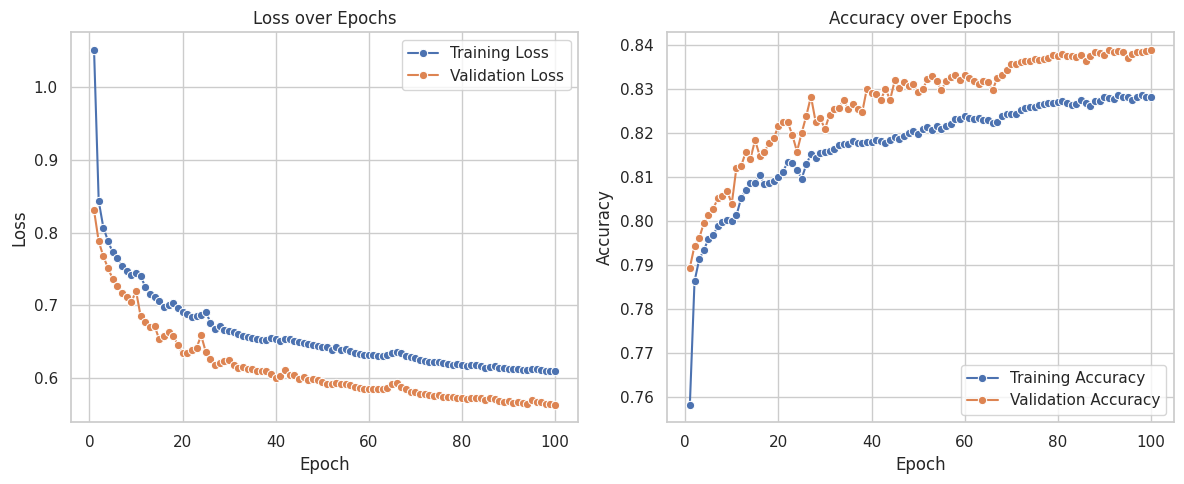

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

def plot_training_history(history):
    """
    Plots training & validation loss and accuracy curves from Keras History object.
    """
    # Extract metrics
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    accuracy = history.history.get('accuracy') or history.history.get('sparse_categorical_accuracy')
    val_accuracy = history.history.get('val_accuracy') or history.history.get('val_sparse_categorical_accuracy')
    epochs = range(1, len(loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs, y=loss, marker='o', label='Training Loss')
    if val_loss:
        sns.lineplot(x=epochs, y=val_loss, marker='o', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    if accuracy:
        plt.subplot(1, 2, 2)
        sns.lineplot(x=epochs, y=accuracy, marker='o', label='Training Accuracy')
        if val_accuracy:
            sns.lineplot(x=epochs, y=val_accuracy, marker='o', label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_training_history(history)

In [ ]:
# Create inference models (simplified for testing)
# For the improved model, we'll create a simpler inference approach
def simple_predict_rnn(eng_input, max_length=32):
    """Simple greedy prediction without beam search"""
    # Clean input
    cleaned = clean_text(eng_input, is_khmer=False)
    if not cleaned:
        return ""

    # Encode input
    enc_seq = eng_tokenizer.texts_to_sequences([cleaned])[0]
    if not enc_seq:
        return ""

    enc_padded = pad_sequences([enc_seq], maxlen=max_eng_len, padding='post')

    # Start with start token
    decoder_input = [khm_tokenizer.word_index['\t']]
    result = []

    for _ in range(max_length):
        # Pad decoder input
        dec_padded = pad_sequences([decoder_input], maxlen=max_khm_len+1, padding='post')

        # Predict
        prediction = model.predict([enc_padded, dec_padded], verbose=0)

        # Get next character (greedy)
        next_char_idx = np.argmax(prediction[0, len(decoder_input)-1, :])

        # Check for end token
        if next_char_idx == khm_tokenizer.word_index['\n']:
            break

        # Add to result
        if next_char_idx in khm_tokenizer.index_word:
            result.append(khm_tokenizer.index_word[next_char_idx])

        # Update decoder input
        decoder_input.append(next_char_idx)

    return ''.join(result)

In [ ]:
# Test the improved model
print("\n=== Testing Improved RNN Model ===")
test_words = ["nov", "srolanh", "knong", "ning", "hning", "jos", "nerk", "knhom", "lorb"]

for word in test_words:
    result = simple_predict_rnn(word)
    print(f"'{word}' -> '{result}'")


=== Testing Improved RNN Model ===
'nov' -> 'ការ'
'srolanh' -> 'ស្រមាំង'
'knong' -> 'ក្រាប់'
'ning' -> 'ការ'
'hning' -> 'ហ្មា'
'jos' -> 'ការ'
'nerk' -> 'ក្រាប់'
'knhom' -> 'ក្រាប់'
'lorb' -> 'ហ្មា'


In [ ]:
simple_predict_rnn("mean")

'ម្អា'

In [ ]:
# Additional debugging function
def debug_prediction(eng_input):
    """Debug what the model is actually predicting"""
    cleaned = clean_text(eng_input, is_khmer=False)
    enc_seq = eng_tokenizer.texts_to_sequences([cleaned])[0]
    enc_padded = pad_sequences([enc_seq], maxlen=max_eng_len, padding='post')

    decoder_input = [khm_tokenizer.word_index['\t']]
    dec_padded = pad_sequences([decoder_input], maxlen=max_khm_len+1, padding='post')

    prediction = model.predict([enc_padded, dec_padded], verbose=0)
    probs = prediction[0, 0, :]  # First position probabilities

    # Get top 5 predictions
    top5_indices = np.argsort(probs)[-5:][::-1]
    print(f"\nDebug for '{eng_input}':")
    for i, idx in enumerate(top5_indices):
        char = khm_tokenizer.index_word.get(idx, f'<{idx}>')
        print(f"  {i+1}. '{char}' (prob: {probs[idx]:.4f})")

print("\n=== Debugging First Predictions ===")
debug_prediction("nov")


=== Debugging First Predictions ===

Debug for 'nov':
  1. 'ក' (prob: 0.1933)
  2. 'ទ' (prob: 0.1144)
  3. 'អ' (prob: 0.1062)
  4. 'គ' (prob: 0.1008)
  5. 'ត' (prob: 0.0982)


In [ ]:
print("\n=== Training History Summary ===")
print(f"Final training loss: {history.history['loss'][-1]:.4f}")
print(f"Final validation loss: {history.history['val_loss'][-1]:.4f}")
if 'accuracy' in history.history:
    print(f"Final training accuracy: {history.history['accuracy'][-1]:.4f}")
    print(f"Final validation accuracy: {history.history['val_accuracy'][-1]:.4f}")


=== Training History Summary ===
Final training loss: 0.6101
Final validation loss: 0.5637
Final training accuracy: 0.8282
Final validation accuracy: 0.8389


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Input, GRU, Dense, Embedding
from tensorflow.keras.models import Model

In [ ]:
# Parameters for GRU model
embed_dim = 32
gru_units = 64  # GRU is more efficient than LSTM, can use same or slightly higher units

# Encoder with GRU
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(len(eng_tokenizer.word_index)+1, embed_dim)(encoder_inputs)
# GRU has only one state (like SimpleRNN but with gating mechanisms)
encoder_gru = GRU(gru_units, return_state=True, dropout=0.3, recurrent_dropout=0.3)
_, encoder_state = encoder_gru(enc_emb)

# Decoder with GRU
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(len(khm_tokenizer.word_index)+1, embed_dim)(decoder_inputs)
decoder_gru = GRU(gru_units, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.3)
decoder_outputs, decoder_state = decoder_gru(dec_emb, initial_state=encoder_state)
decoder_dense = Dense(len(khm_tokenizer.word_index)+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

model2 = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model2.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])

print("\n6. GRU Model summary:")
model2.summary()


6. GRU Model summary:


Model: "functional_12"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_23      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_21        │ (None, None, 32)  │        896 │ input_layer_22[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_22        │ (None, None, 32)  │      2,592 │ input_layer_23[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_12 (GRU)        │ [(None, 64),      │     18,816 │ embedding_21[0][… │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_13 (GRU)        │ [(None, None,     │     18,816 │ embedding_22[0][… │
│                     │ 64), (None, 64)]  │            │ gru_12[0][1]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, None, 81)  │      5,265 │ gru_13[0][0]      │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 46,385 (181.19 KB)

 Trainable params: 46,385 (181.19 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\nTraining GRU Model:")
# Enhanced callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

history2 = model2.fit(
    [encoder_data, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),  # Add channel dimension
    batch_size=64,
    epochs=50,
    validation_split=0.2,
    verbose=1,
    callbacks=[callbacks]
)


Training GRU Model:
Epoch 1/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 57s 158ms/step - accuracy: 0.7835 - loss: 0.8949 - val_accuracy: 0.7946 - val_loss: 0.8077 - learning_rate: 0.0010
Epoch 2/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 83s 160ms/step - accuracy: 0.7947 - loss: 0.8070 - val_accuracy: 0.7986 - val_loss: 0.7769 - learning_rate: 0.0010
Epoch 3/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 81s 159ms/step - accuracy: 0.7979 - loss: 0.7817 - val_accuracy: 0.8032 - val_loss: 0.7559 - learning_rate: 0.0010
Epoch 4/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 57s 158ms/step - accuracy: 0.8011 - loss: 0.7626 - val_accuracy: 0.8072 - val_loss: 0.7318 - learning_rate: 0.0010
Epoch 5/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 57s 158ms/step - accuracy: 0.8040 - loss: 0.7424 - val_accuracy: 0.8100 - val_loss: 0.7100 - learning_rate: 0.0010
Epoch 6/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 58s 161ms/step - accuracy: 0.8091 - loss: 0.7152 - val_accuracy: 0.8142 - val_loss: 0.6902 - learning_rate: 0.0010
Epoch 7/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 82s 161ms

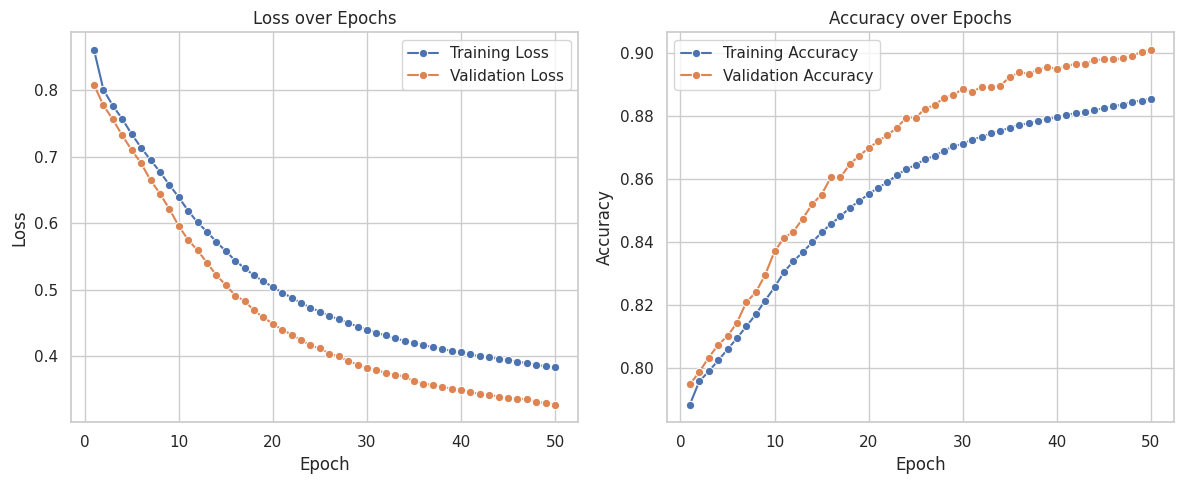

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

def plot_training_history(history):
    """
    Plots training & validation loss and accuracy curves from Keras History object.
    """
    # Extract metrics
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    accuracy = history.history.get('accuracy') or history.history.get('sparse_categorical_accuracy')
    val_accuracy = history.history.get('val_accuracy') or history.history.get('val_sparse_categorical_accuracy')
    epochs = range(1, len(loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs, y=loss, marker='o', label='Training Loss')
    if val_loss:
        sns.lineplot(x=epochs, y=val_loss, marker='o', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    if accuracy:
        plt.subplot(1, 2, 2)
        sns.lineplot(x=epochs, y=accuracy, marker='o', label='Training Accuracy')
        if val_accuracy:
            sns.lineplot(x=epochs, y=val_accuracy, marker='o', label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_training_history(history2)

In [ ]:
# Create inference models for GRU
encoder_model = Model(encoder_inputs, encoder_state)

decoder_state_input = Input(shape=(gru_units,))  # Only one state for GRU
decoder_outputs, decoder_state = decoder_gru(dec_emb, initial_state=decoder_state_input)
decoder_outputs = decoder_dense(decoder_outputs)

decoder_model = Model(
    [decoder_inputs, decoder_state_input],
    [decoder_outputs, decoder_state]
)

# Prediction function for GRU (single state like RNN)
def predict_khmer_gru(eng_input, beam_width=3):
    # Clean and encode input
    cleaned = clean_text(eng_input, is_khmer=False)
    enc_seq = eng_tokenizer.texts_to_sequences([cleaned])[0]
    enc_padded = pad_sequences([enc_seq], maxlen=max_eng_len, padding='post')

    # Get initial state from encoder (only one state for GRU)
    initial_state = encoder_model.predict(enc_padded, verbose=0)

    # Initialize beam search
    beams = [{
        'seq': [],
        'prob': 1.0,
        'state': initial_state
    }]

    for step in range(max_khm_len):
        new_beams = []
        for beam in beams:
            # Prepare decoder input
            last_char = beam['seq'][-1] if beam['seq'] else khm_tokenizer.word_index['\t']
            target_seq = np.array([[last_char]])

            # Predict next step (only one state for GRU)
            outputs, new_state = decoder_model.predict(
                [target_seq, beam['state']],
                verbose=0
            )

            # Get top candidates
            probs = outputs[0, -1]
            top_indices = np.argsort(probs)[-beam_width:]

            for idx in top_indices:
                char_prob = probs[idx]
                if char_prob > 1e-8:  # Avoid very low probabilities
                    new_beam = {
                        'seq': beam['seq'] + [idx],
                        'prob': beam['prob'] * char_prob,
                        'state': new_state
                    }
                    new_beams.append(new_beam)

        # Keep top beams
        beams = sorted(new_beams, key=lambda x: x['prob'], reverse=True)[:beam_width]

        # Check if we hit end token
        if beams and beams[0]['seq'] and beams[0]['seq'][-1] == khm_tokenizer.word_index['\n']:
            break

    # Convert best sequence
    best_seq = beams[0]['seq'] if beams else []
    decoded = []
    for idx in best_seq:
        if idx == khm_tokenizer.word_index['\n']:
            break
        if idx in khm_tokenizer.index_word:
            decoded.append(khm_tokenizer.index_word[idx])

    return ''.join(decoded)

# Enhanced prediction function with temperature sampling
def predict_khmer_gru_temperature(eng_input, temperature=0.7):
    """Alternative prediction with temperature sampling for more diverse outputs"""
    # Clean and encode input
    cleaned = clean_text(eng_input, is_khmer=False)
    enc_seq = eng_tokenizer.texts_to_sequences([cleaned])[0]
    enc_padded = pad_sequences([enc_seq], maxlen=max_eng_len, padding='post')

    # Get initial state from encoder
    state = encoder_model.predict(enc_padded, verbose=0)

    # Initialize with start token
    target_seq = [khm_tokenizer.word_index['\t']]

    for _ in range(max_khm_len):
        # Predict next character
        input_seq = np.array([[target_seq[-1]]])
        outputs, state = decoder_model.predict([input_seq, state], verbose=0)

        # Apply temperature
        predictions = outputs[0, -1] / temperature
        predictions = np.exp(predictions) / np.sum(np.exp(predictions))

        # Sample from distribution
        next_char = np.random.choice(len(predictions), p=predictions)

        if next_char == khm_tokenizer.word_index['\n']:
            break

        target_seq.append(next_char)

    # Convert to text
    decoded = []
    for idx in target_seq[1:]:  # Skip start token
        if idx in khm_tokenizer.index_word:
            decoded.append(khm_tokenizer.index_word[idx])

    return ''.join(decoded)

In [ ]:
# Test the GRU model
print("\n8. Testing GRU Model:")
test_words = [ "nov",
              "srolanh",
              "knong",
              "ning",
              "hning",
              "jos",
              "nerk",
              "knhom",
              "lorb"]

print("\n--- Beam Search Results ---")
for word in test_words:
    result = predict_khmer_gru(word)
    print(f"'{word}' -> '{result}'")

print("\n--- Temperature Sampling Results ---")
for word in test_words[:3]:  # Test fewer words with multiple samples
    print(f"'{word}':")
    for i in range(3):  # Multiple samples
        result = predict_khmer_gru_temperature(word, temperature=0.8)
        print(f"  Sample {i+1}: '{result}'")
    print()



8. Testing GRU Model:

--- Beam Search Results ---
'nov' -> 'នូវ'
'srolanh' -> 'ស្រឡាញ់'
'knong' -> 'ក្នង់'
'ning' -> 'និង'
'hning' -> 'ហ្នឹង'
'jos' -> 'ចាស់'
'nerk' -> 'នាក់'
'knhom' -> 'ខ្នាំ'
'lorb' -> 'ឡប់'

--- Temperature Sampling Results ---
'nov':
  Sample 1: 'ើឥៀ៌សយឍទ<unk>៌្ូថៅ់ទ៌ថីោៃិំ្'
  Sample 2: 'ឪឍឰកឃ៍ត។វឫឆងតឰ	គឡ៍ោ៌ៃឦឧ់'
  Sample 3: 'ុឪឦឍ៊ាំជឫឧឱ៏ឆ័ែតឦូទ៎ើមឹណ'

'srolanh':
  Sample 1: 'ឈូ័គភាណើកឧ។ផៀសេឺឫ៎ឩ៌ឺហយះ'
  Sample 2: 'ងឃឭៈ់ឍញឮសឆប្ដ៏ៃោឺំ៉ឩឬឥឋឍ'
  Sample 3: 'គផរឧវ៍'

'knong':
  Sample 1: '័ដំឺឦភវ៎ុត្ហឭផ។សណឥុថផឪដែ'
  Sample 2: 'ឬឍ័ទណ័ឯធឍ៎ៈឯ៎ណៈមឪឹឧឿៃរៈៀ'
  Sample 3: 'កត៊ឧៅបញដខឿ'



In [ ]:
predict_khmer_gru("khnong")

'ខ្នង់'

In [ ]:

# Save the entire model (architecture + weights)
model2.save('gru_khmer_transliterator.keras')

# Save tokenizers and metadata
import pickle
with open('gru_transliteration_assets.pkl', 'wb') as f:
    pickle.dump({
        'eng_tokenizer': eng_tokenizer,
        'khm_tokenizer': khm_tokenizer,
        'max_eng_len': max_eng_len,
        'max_khm_len': max_khm_len
    }, f)

print("Saved: model.keras + transliteration_assets.pkl")

Saved: model.keras + transliteration_assets.pkl


In [ ]:
def calculate_accuracy(split=0.001):
    """
    Evaluates prediction accuracy and prints each sample line by line.
    """
    test_samples = int(len(encoder_data) * split)
    correct = 0

    print(f"\nEvaluating on {test_samples} samples...\n")

    for i in range(test_samples):
        eng = ''.join([eng_tokenizer.index_word[idx] for idx in encoder_data[i] if idx != 0])
        true_khm = ''.join([khm_tokenizer.index_word[idx] for idx in decoder_targets[i] if idx not in {0, khm_tokenizer.word_index['\n']}])
        pred_khm = predict_khmer_gru(eng)

        print(f"{i}: ENG='{eng}' | TRUE='{true_khm}' | PRED='{pred_khm}'")

        if pred_khm == true_khm:
            correct += 1

    accuracy = correct / test_samples * 100
    print(f"\n✅ Accuracy: {accuracy:.2f}% ({correct}/{test_samples} correct)")

    return accuracy / 100


In [ ]:
calculate_accuracy()


Evaluating on 28 samples...

0: ENG='brodae' | TRUE='ប្រដែ' | PRED='ប្រដែ'
1: ENG='aasangkheyy' | TRUE='អសង្ខៃយ' | PRED='អង្សាយាក'
2: ENG='chhatkophey' | TRUE='ឆាតកភ័យ' | PRED='ចត្ថាពាយ'
3: ENG='topvosompheareak' | TRUE='ទព្វសម្ភារៈ' | PRED='ទុក្បិភាពិការ'
4: ENG='touchkroyean' | TRUE='ទោចក្រយាន' | PRED='ទុក្ខវាន'
5: ENG='neari' | TRUE='នារី' | PRED='នារី'
6: ENG='srech' | TRUE='ស្រិចៗ' | PRED='ស្រិច'
7: ENG='hothelirng' | TRUE='ហត្ថិលិង្គ' | PRED='ហត្ថិង្គ'
8: ENG='terng' | TRUE='តឹង' | PRED='ទឹង'
9: ENG='aathimott' | TRUE='អធិមត្ត' | PRED='អធិមត្ត'
10: ENG='behbet' | TRUE='បេះបិទ' | PRED='ប៉ប្ចិត'
11: ENG='aay' | TRUE='អាយ' | PRED='អាយ'
12: ENG='mohoesa' | TRUE='មហឹសា' | PRED='មហាស'
13: ENG='thengthoung' | TRUE='ធេងធោង' | PRED='ទឹងទ្រង'
14: ENG='pirnng' | TRUE='ប៉ុណ្ណឹង' | PRED='ពិង្គ'
15: ENG='costarica' | TRUE='កូស្តារីកា' | PRED='នាទ្រាស់'
16: ENG='tomrek' | TRUE='តម្រេក' | PRED='តម្រឹក'
17: ENG='yak' | TRUE='យ៉ាក' | PRED='យក'
18: ENG='trov' | TRUE='ត្រូវ' | PRED='ត្រវ'
19: ENG='

0.14285714285714285

### Bidirectional GRU

In [ ]:
from tensorflow.keras.layers import Input, GRU, Dense, Embedding, Bidirectional, Concatenate
from tensorflow.keras.models import Model

# Parameters
embed_dim = 32
gru_units = 64

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(len(eng_tokenizer.word_index)+1, embed_dim)(encoder_inputs)
encoder_gru = Bidirectional(GRU(gru_units, return_state=True, dropout=0.3, recurrent_dropout=0.3))
_, forward_state, backward_state = encoder_gru(enc_emb)
encoder_state = Concatenate()([forward_state, backward_state])
encoder_state = Dense(gru_units, activation='tanh')(encoder_state)  # project to decoder units

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(len(khm_tokenizer.word_index)+1, embed_dim)(decoder_inputs)
decoder_gru = GRU(gru_units, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.3)
decoder_outputs, _ = decoder_gru(dec_emb, initial_state=encoder_state)
decoder_dense = Dense(len(khm_tokenizer.word_index)+1, activation='softmax')
decoder_outputs = decoder_dense(decoder_outputs)

# Build and compile
model_bi_gru = Model([encoder_inputs, decoder_inputs], decoder_outputs)
model_bi_gru.compile(optimizer="adam", loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_bi_gru.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, None, 32)  │        896 │ input_layer[0][0] │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ [(None, 128),     │     37,632 │ embedding[0][0]   │
│ (Bidirectional)     │ (None, 64),       │            │                   │
│                     │ (None, 64)]       │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_1       │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 128)       │          0 │ bidirectional[0]… │
│ (Concatenate)       │                   │            │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_1         │ (None, None, 32)  │      2,592 │ input_layer_1[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 64)        │      8,256 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_1 (GRU)         │ [(None, None,     │     18,816 │ embedding_1[0][0… │
│                     │ 64), (None, 64)]  │            │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, None, 81)  │      5,265 │ gru_1[0][0]       │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 73,457 (286.94 KB)

 Trainable params: 73,457 (286.94 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\nTraining Bidirectional GRU Model:")
# Enhanced callbacks
callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

history3 = model_bi_gru.fit(
    [encoder_data, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),  # Add channel dimension
    batch_size=64,
    epochs=50,
    validation_split=0.2,
    verbose=1,
    callbacks=[callbacks]
)


Training Bidirectional GRU Model:
Epoch 1/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 99s 232ms/step - accuracy: 0.7402 - loss: 1.5459 - val_accuracy: 0.8102 - val_loss: 0.7737 - learning_rate: 0.0010
Epoch 2/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 134s 225ms/step - accuracy: 0.8134 - loss: 0.7517 - val_accuracy: 0.8328 - val_loss: 0.6463 - learning_rate: 0.0010
Epoch 3/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 81s 222ms/step - accuracy: 0.8329 - loss: 0.6461 - val_accuracy: 0.8507 - val_loss: 0.5619 - learning_rate: 0.0010
Epoch 4/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 83s 226ms/step - accuracy: 0.8477 - loss: 0.5725 - val_accuracy: 0.8643 - val_loss: 0.4982 - learning_rate: 0.0010
Epoch 5/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 82s 226ms/step - accuracy: 0.8587 - loss: 0.5172 - val_accuracy: 0.8730 - val_loss: 0.4505 - learning_rate: 0.0010
Epoch 6/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 81s 224ms/step - accuracy: 0.8678 - loss: 0.4744 - val_accuracy: 0.8828 - val_loss: 0.4130 - learning_rate: 0.0010
Epoch 7/50
358/358 ━━━━━━━━━━━━━━━

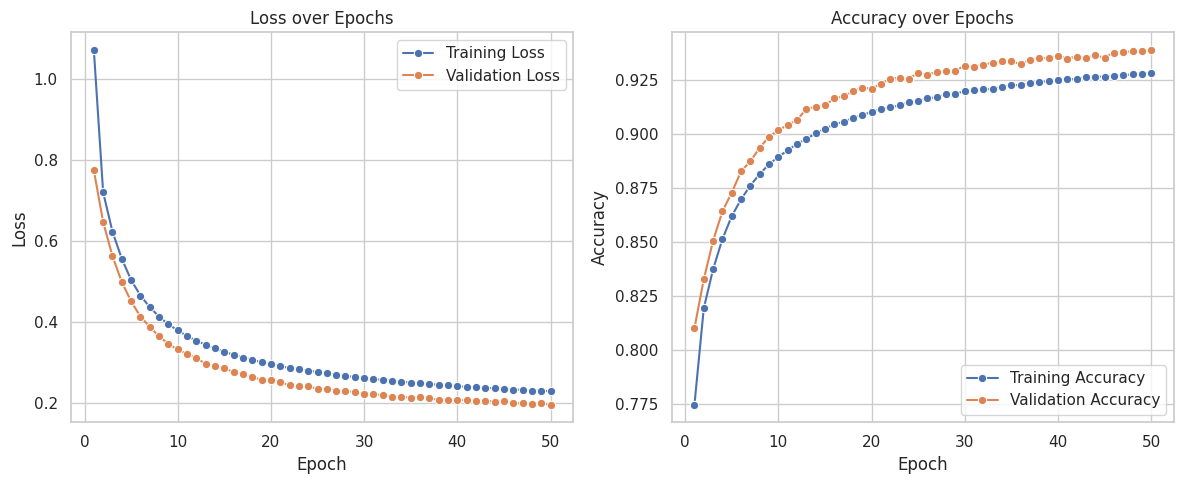

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

def plot_training_history(history):
    """
    Plots training & validation loss and accuracy curves from Keras History object.
    """
    # Extract metrics
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    accuracy = history.history.get('accuracy') or history.history.get('sparse_categorical_accuracy')
    val_accuracy = history.history.get('val_accuracy') or history.history.get('val_sparse_categorical_accuracy')
    epochs = range(1, len(loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs, y=loss, marker='o', label='Training Loss')
    if val_loss:
        sns.lineplot(x=epochs, y=val_loss, marker='o', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    if accuracy:
        plt.subplot(1, 2, 2)
        sns.lineplot(x=epochs, y=accuracy, marker='o', label='Training Accuracy')
        if val_accuracy:
            sns.lineplot(x=epochs, y=val_accuracy, marker='o', label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_training_history(history3)

In [ ]:
model_bi_gru.save('bi_gru_khmer_transliterator.keras')

In [ ]:
from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# -------------------------
# Encoder inference model
# -------------------------
encoder_model_bi = Model(encoder_inputs, encoder_state)  # already projected to decoder units

# -------------------------
# Decoder inference model
# -------------------------
decoder_state_input = Input(shape=(gru_units,))
decoder_outputs_inf, decoder_state_inf = decoder_gru(dec_emb, initial_state=decoder_state_input)
decoder_outputs_inf = decoder_dense(decoder_outputs_inf)

decoder_model_bi = Model(
    [decoder_inputs, decoder_state_input],
    [decoder_outputs_inf, decoder_state_inf]
)

# -------------------------
# Prediction function
# -------------------------
def predict_khmer_bi_gru(eng_input, beam_width=3):
    # Clean and encode input
    cleaned = clean_text(eng_input, is_khmer=False)
    enc_seq = eng_tokenizer.texts_to_sequences([cleaned])[0]
    enc_padded = pad_sequences([enc_seq], maxlen=max_eng_len, padding='post')

    # Get initial state from encoder
    initial_state = encoder_model_bi.predict(enc_padded, verbose=0)

    # Initialize beam search
    beams = [{'seq': [], 'prob': 1.0, 'state': initial_state}]

    for step in range(max_khm_len):
        new_beams = []
        for beam in beams:
            last_char = beam['seq'][-1] if beam['seq'] else khm_tokenizer.word_index['\t']
            target_seq = np.array([[last_char]])

            # Predict next character
            outputs, new_state = decoder_model_bi.predict([target_seq, beam['state']], verbose=0)

            probs = outputs[0, -1]
            top_indices = np.argsort(probs)[-beam_width:]

            for idx in top_indices:
                char_prob = probs[idx]
                if char_prob > 1e-8:
                    new_beam = {
                        'seq': beam['seq'] + [idx],
                        'prob': beam['prob'] * char_prob,
                        'state': new_state
                    }
                    new_beams.append(new_beam)

        beams = sorted(new_beams, key=lambda x: x['prob'], reverse=True)[:beam_width]

        # Stop if end token predicted
        if beams and beams[0]['seq'] and beams[0]['seq'][-1] == khm_tokenizer.word_index['\n']:
            break

    # Decode best sequence
    best_seq = beams[0]['seq'] if beams else []
    decoded = []
    for idx in best_seq:
        if idx == khm_tokenizer.word_index['\n']:
            break
        if idx in khm_tokenizer.index_word:
            decoded.append(khm_tokenizer.index_word[idx])

    return ''.join(decoded)

# -------------------------
# Optional: temperature sampling version
# -------------------------
def predict_khmer_bi_gru_temperature(eng_input, temperature=0.7):
    cleaned = clean_text(eng_input, is_khmer=False)
    enc_seq = eng_tokenizer.texts_to_sequences([cleaned])[0]
    enc_padded = pad_sequences([enc_seq], maxlen=max_eng_len, padding='post')

    state = encoder_model_bi.predict(enc_padded, verbose=0)
    target_seq = [khm_tokenizer.word_index['\t']]

    for _ in range(max_khm_len):
        input_seq = np.array([[target_seq[-1]]])
        outputs, state = decoder_model_bi.predict([input_seq, state], verbose=0)

        predictions = outputs[0, -1] / temperature
        predictions = np.exp(predictions) / np.sum(np.exp(predictions))
        next_char = np.random.choice(len(predictions), p=predictions)

        if next_char == khm_tokenizer.word_index['\n']:
            break

        target_seq.append(next_char)

    decoded = [khm_tokenizer.index_word[idx] for idx in target_seq[1:] if idx in khm_tokenizer.index_word]
    return ''.join(decoded)


In [ ]:
# Test the GRU model
print("\n8. Testing GRU Model:")

test_words = [ "nov",
              "srolanh",
              "knong",
              "ning",
              "hning",
              "jos",
              "nerk",
              "knhom",
              "lorb"]

print("\n--- Beam Search Results ---")
for word in test_words:
    result = predict_khmer_bi_gru(word)
    print(f"'{word}' -> '{result}'")


8. Testing GRU Model:

--- Beam Search Results ---
'nov' -> 'នៅ'
'srolanh' -> 'ស្រឡាញ'
'knong' -> 'ក្នុង'
'ning' -> 'នីង'
'hning' -> 'ហ្នីង'
'jos' -> 'ចុស'
'nerk' -> 'នើក'
'knhom' -> 'ខ្ញម'
'lorb' -> 'ឡប់'


In [ ]:
def calculate_accuracy(split=0.001):
    """
    Evaluates prediction accuracy and prints each sample line by line.
    """
    test_samples = int(len(encoder_data) * split)
    correct = 0

    print(f"\nEvaluating on {test_samples} samples...\n")

    for i in range(test_samples):
        eng = ''.join([eng_tokenizer.index_word[idx] for idx in encoder_data[i] if idx != 0])
        true_khm = ''.join([khm_tokenizer.index_word[idx] for idx in decoder_targets[i] if idx not in {0, khm_tokenizer.word_index['\n']}])
        pred_khm = predict_khmer_bi_gru(eng)

        print(f"{i}: ENG='{eng}' | TRUE='{true_khm}' | PRED='{pred_khm}'")

        if pred_khm == true_khm:
            correct += 1

    accuracy = correct / test_samples * 100
    print(f"\n✅ Accuracy: {accuracy:.2f}% ({correct}/{test_samples} correct)")

    return accuracy / 100


In [ ]:
calculate_accuracy()


Evaluating on 28 samples...

0: ENG='brodae' | TRUE='ប្រដែ' | PRED='ប្រដែ'
1: ENG='aasangkheyy' | TRUE='អសង្ខៃយ' | PRED='អសង្ខៃ'
2: ENG='chhatkophey' | TRUE='ឆាតកភ័យ' | PRED='ឆត្កភ័យ'
3: ENG='topvosompheareak' | TRUE='ទព្វសម្ភារៈ' | PRED='ទព្វសម្ភាស'
4: ENG='touchkroyean' | TRUE='ទោចក្រយាន' | PRED='ទោជគ្រាយ'
5: ENG='neari' | TRUE='នារី' | PRED='នារី'
6: ENG='srech' | TRUE='ស្រិចៗ' | PRED='ស្រិច'
7: ENG='hothelirng' | TRUE='ហត្ថិលិង្គ' | PRED='ហត្ថិលី'
8: ENG='terng' | TRUE='តឹង' | PRED='ទើង'
9: ENG='aathimott' | TRUE='អធិមត្ត' | PRED='អធិមត្ត'
10: ENG='behbet' | TRUE='បេះបិទ' | PRED='បេះប៉ិត'
11: ENG='aay' | TRUE='អាយ' | PRED='អាយ'
12: ENG='mohoesa' | TRUE='មហឹសា' | PRED='មហេសា'
13: ENG='thengthoung' | TRUE='ធេងធោង' | PRED='ធិងដោង'
14: ENG='pirnng' | TRUE='ប៉ុណ្ណឹង' | PRED='ពើង'
15: ENG='costarica' | TRUE='កូស្តារីកា' | PRED='កុត្រិសា'
16: ENG='tomrek' | TRUE='តម្រេក' | PRED='តម្រេក'
17: ENG='yak' | TRUE='យ៉ាក' | PRED='យក'
18: ENG='trov' | TRUE='ត្រូវ' | PRED='ត្រៅ'
19: ENG='aomros' |

0.2857142857142857

In [ ]:
predict_khmer_bi_gru("mean")

'មាន'

### Bidirectional Attention GRU

In [ ]:
print("TF version:", tf.__version__)

TF version: 2.17.0


In [ ]:
# Parameters
embed_dim = 32
gru_units = 64

# Encoder
encoder_inputs = Input(shape=(None,))
enc_emb = Embedding(len(eng_tokenizer.word_index)+1, embed_dim)(encoder_inputs)
encoder_gru = Bidirectional(GRU(gru_units, return_sequences=True, dropout=0.3, recurrent_dropout=0.3))
encoder_outputs = encoder_gru(enc_emb)  # (batch, timesteps, 2*gru_units = 128)

# Decoder
decoder_inputs = Input(shape=(None,))
dec_emb = Embedding(len(khm_tokenizer.word_index)+1, embed_dim)(decoder_inputs)
decoder_gru = GRU(gru_units, return_sequences=True, return_state=True, dropout=0.3, recurrent_dropout=0.3)
decoder_outputs, decoder_state = decoder_gru(dec_emb)

# Project encoder outputs to match decoder units for attention
encoder_proj = TimeDistributed(Dense(gru_units))(encoder_outputs)  # (batch, timesteps, 64)

# Attention mechanism
attention = AdditiveAttention()
context = attention([decoder_outputs, encoder_proj])

# Concatenate context with decoder outputs
decoder_combined = Concatenate(axis=-1)([decoder_outputs, context])
decoder_dense = Dense(len(khm_tokenizer.word_index)+1, activation='softmax')
final_outputs = decoder_dense(decoder_combined)

# Build training model
model_bi_gru_attention = Model([encoder_inputs, decoder_inputs], final_outputs)
model_bi_gru_attention.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model_bi_gru_attention.summary()

Model: "functional_13"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_22      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_23      │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_8         │ (None, None, 32)  │        896 │ input_layer_22[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_9         │ (None, None, 32)  │      2,592 │ input_layer_23[0… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_3     │ (None, None, 128) │     37,632 │ embedding_8[0][0] │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_7 (GRU)         │ [(None, None,     │     18,816 │ embedding_9[0][0] │
│                     │ 64), (None, 64)]  │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ time_distributed_9  │ (None, None, 64)  │      8,256 │ bidirectional_3[… │
│ (TimeDistributed)   │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ additive_attention… │ (None, None, 64)  │         64 │ gru_7[0][0],      │
│ (AdditiveAttention) │                   │            │ time_distributed… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_7       │ (None, None, 128) │          0 │ gru_7[0][0],      │
│ (Concatenate)       │                   │            │ additive_attenti… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_13 (Dense)    │ (None, None, 81)  │     10,449 │ concatenate_7[0]… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 78,705 (307.44 KB)

 Trainable params: 78,705 (307.44 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
print("\nTraining Bidirectional GRU Model:")

callbacks = [
    EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.5,
        patience=3,
        min_lr=1e-7,
        verbose=1
    )
]

history4 = model_bi_gru_attention.fit(
    [encoder_data, decoder_input_data],
    np.expand_dims(decoder_target_data, -1),  # Add channel dimension
    batch_size=64,
    epochs=50,
    validation_split=0.2,
    verbose=1,
    callbacks=[callbacks]
)


Training Bidirectional GRU Model:
Epoch 1/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 23s 46ms/step - accuracy: 0.7310 - loss: 1.4411 - val_accuracy: 0.7899 - val_loss: 0.8165 - learning_rate: 0.0010
Epoch 2/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.8030 - loss: 0.7620 - val_accuracy: 0.8552 - val_loss: 0.5323 - learning_rate: 0.0010
Epoch 3/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.8613 - loss: 0.5021 - val_accuracy: 0.8952 - val_loss: 0.3552 - learning_rate: 0.0010
Epoch 4/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.8935 - loss: 0.3620 - val_accuracy: 0.9171 - val_loss: 0.2754 - learning_rate: 0.0010
Epoch 5/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 16s 43ms/step - accuracy: 0.9114 - loss: 0.2963 - val_accuracy: 0.9295 - val_loss: 0.2356 - learning_rate: 0.0010
Epoch 6/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 15s 43ms/step - accuracy: 0.9238 - loss: 0.2534 - val_accuracy: 0.9382 - val_loss: 0.2051 - learning_rate: 0.0010
Epoch 7/50
358/358 ━━━━━━━━━━━━━━━━━━━━ 1

In [ ]:
model_bi_gru_attention.save('bi_gru_attention_khmer_transliterator.keras')

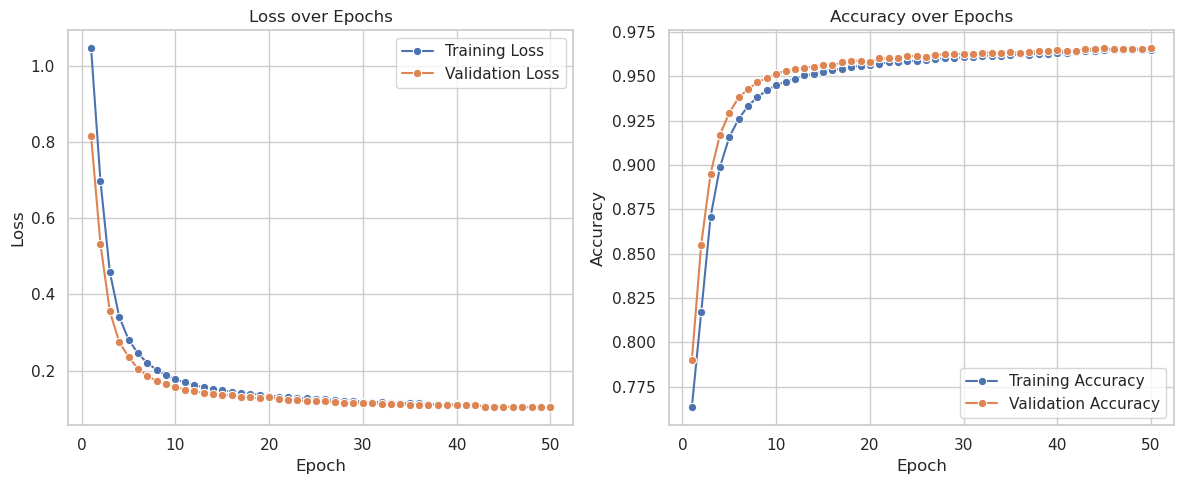

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set seaborn style
sns.set(style="whitegrid")

def plot_training_history(history):
    """
    Plots training & validation loss and accuracy curves from Keras History object.
    """
    # Extract metrics
    loss = history.history.get('loss')
    val_loss = history.history.get('val_loss')
    accuracy = history.history.get('accuracy') or history.history.get('sparse_categorical_accuracy')
    val_accuracy = history.history.get('val_accuracy') or history.history.get('val_sparse_categorical_accuracy')
    epochs = range(1, len(loss) + 1)

    # Plot Loss
    plt.figure(figsize=(12,5))
    plt.subplot(1, 2, 1)
    sns.lineplot(x=epochs, y=loss, marker='o', label='Training Loss')
    if val_loss:
        sns.lineplot(x=epochs, y=val_loss, marker='o', label='Validation Loss')
    plt.title('Loss over Epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plot Accuracy
    if accuracy:
        plt.subplot(1, 2, 2)
        sns.lineplot(x=epochs, y=accuracy, marker='o', label='Training Accuracy')
        if val_accuracy:
            sns.lineplot(x=epochs, y=val_accuracy, marker='o', label='Validation Accuracy')
        plt.title('Accuracy over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

    plt.tight_layout()
    plt.show()

# Example usage
plot_training_history(history4)

In [ ]:
# -------------------------
# PREDICTION FUNCTION
# -------------------------
def predict_khmer_bi_gru_attention(eng_input, beam_width=3, max_length=50):
    """
    Predict Khmer translation using bidirectional GRU with attention
    """
    # Clean and encode input
    cleaned = clean_text(eng_input, is_khmer=False)
    enc_seq = eng_tokenizer.texts_to_sequences([cleaned])[0]
    enc_padded = pad_sequences([enc_seq], maxlen=max_eng_len, padding='post')

    # Get encoder outputs and projections
    encoder_outputs, encoder_proj = encoder_model.predict(enc_padded, verbose=0)

    # Initialize decoder state (zeros for GRU)
    initial_state = np.zeros((1, gru_units))

    # Start token
    start_token = khm_tokenizer.word_index.get('\t', 1)
    end_token = khm_tokenizer.word_index.get('\n', 2)

    # Initialize beam search
    beams = [{
        'seq': [start_token],
        'prob': 1.0,
        'state': initial_state,
        'finished': False
    }]

    finished_beams = []

    for step in range(max_length):
        if not beams:  # All beams finished
            break

        new_beams = []

        for beam in beams:
            if beam['finished']:
                finished_beams.append(beam)
                continue

            # Prepare decoder input (last token)
            last_token = beam['seq'][-1]
            target_seq = np.array([[last_token]])

            # Predict next token
            outputs, new_state = decoder_model.predict([
                target_seq,
                beam['state'],
                encoder_proj
            ], verbose=0)

            # Get probabilities for next token
            probs = outputs[0, -1, :]  # Last timestep, all vocab

            # Get top candidates
            top_indices = np.argsort(probs)[-beam_width:]

            for idx in top_indices:
                token_prob = probs[idx]
                if token_prob > 1e-8:  # Avoid very low probabilities
                    new_seq = beam['seq'] + [idx]
                    new_prob = beam['prob'] * token_prob

                    # Check if finished (end token or max length)
                    finished = (idx == end_token) or (len(new_seq) >= max_length)

                    new_beam = {
                        'seq': new_seq,
                        'prob': new_prob,
                        'state': new_state,
                        'finished': finished
                    }

                    if finished:
                        finished_beams.append(new_beam)
                    else:
                        new_beams.append(new_beam)

        # Keep only top beams for next iteration
        beams = sorted(new_beams, key=lambda x: x['prob'], reverse=True)[:beam_width]

        # If we have enough finished beams, we can stop early
        if len(finished_beams) >= beam_width:
            break

    # Combine finished and unfinished beams
    all_beams = finished_beams + beams
    if not all_beams:
        return ""

    # Get best beam
    best_beam = max(all_beams, key=lambda x: x['prob'])
    best_seq = best_beam['seq']

    # Decode sequence to text
    decoded = []
    for idx in best_seq:
        if idx == start_token:  # Skip start token
            continue
        if idx == end_token:    # Stop at end token
            break
        if idx in khm_tokenizer.index_word:
            decoded.append(khm_tokenizer.index_word[idx])

    return ''.join(decoded)

In [ ]:
# Test the GRU model
print("\nTesting Bidirectional Attention GRU Model:")
test_words = [ "nov",
              "srolanh",
              "knong",
              "ning",
              "hning",
              "jos",
              "nerk",
              "knhom",
              "lorb"]

print("\n--- Beam Search Results ---")
for word in test_words:
    result = predict_khmer_bi_gru_attention(word)
    print(f"'{word}' -> '{result}'")



Testing Bidirectional Attention GRU Model:

--- Beam Search Results ---
'nov' -> 'នៅ'
'srolanh' -> 'ស្រឡាញ់'
'knong' -> 'គ្នង់'
'ning' -> 'និង'
'hning' -> 'ហ្នីង'
'jos' -> 'ចុះ'
'nerk' -> 'នើក'
'knhom' -> 'ក្ញម'
'lorb' -> 'ឡប់'


In [ ]:
def calculate_accuracy(split=0.001):
    """
    Evaluates prediction accuracy and prints each sample line by line.
    """
    test_samples = int(len(encoder_data) * split)
    correct = 0

    print(f"\nEvaluating on {test_samples} samples...\n")

    for i in range(test_samples):
        eng = ''.join([eng_tokenizer.index_word[idx] for idx in encoder_data[i] if idx != 0])
        true_khm = ''.join([khm_tokenizer.index_word[idx] for idx in decoder_targets[i] if idx not in {0, khm_tokenizer.word_index['\n']}])
        pred_khm = predict_khmer_bi_gru_attention(eng)

        print(f"{i}: ENG='{eng}' | TRUE='{true_khm}' | PRED='{pred_khm}'")

        if pred_khm == true_khm:
            correct += 1

    accuracy = correct / test_samples * 100
    print(f"\n✅ Accuracy: {accuracy:.2f}% ({correct}/{test_samples} correct)")

    return accuracy / 100


In [ ]:
calculate_accuracy()


Evaluating on 28 samples...

0: ENG='brodae' | TRUE='ប្រដែ' | PRED='ប្រដែ'
1: ENG='aasangkheyy' | TRUE='អសង្ខៃយ' | PRED='អសង្ខេយ្'
2: ENG='chhatkophey' | TRUE='ឆាតកភ័យ' | PRED='ឆាតកភ័យ'
3: ENG='topvosompheareak' | TRUE='ទព្វសម្ភារៈ' | PRED='ទព្វសម្ភារ'
4: ENG='touchkroyean' | TRUE='ទោចក្រយាន' | PRED='ទោចក្រយាន'
5: ENG='neari' | TRUE='នារី' | PRED='នារី'
6: ENG='srech' | TRUE='ស្រិចៗ' | PRED='ស្រិច'
7: ENG='hothelirng' | TRUE='ហត្ថិលិង្គ' | PRED='ហត្ថិលិង'
8: ENG='terng' | TRUE='តឹង' | PRED='ទឹង'
9: ENG='aathimott' | TRUE='អធិមត្ត' | PRED='អធិមត្ត'
10: ENG='behbet' | TRUE='បេះបិទ' | PRED='បេះបិត'
11: ENG='aay' | TRUE='អាយ' | PRED='អាយ'
12: ENG='mohoesa' | TRUE='មហឹសា' | PRED='មហឹសា'
13: ENG='thengthoung' | TRUE='ធេងធោង' | PRED='ថិងថូង'
14: ENG='pirnng' | TRUE='ប៉ុណ្ណឹង' | PRED='ពឹង'
15: ENG='costarica' | TRUE='កូស្តារីកា' | PRED='កុស្តារិកា'
16: ENG='tomrek' | TRUE='តម្រេក' | PRED='ទម្រេក'
17: ENG='yak' | TRUE='យ៉ាក' | PRED='យាក់'
18: ENG='trov' | TRUE='ត្រូវ' | PRED='ត្រៅ'
19: ENG='ao

0.35714285714285715

In [ ]:
def predict_khmer_top3(eng_input, beam_width=5, max_length=32, num_suggestions=3):
    """
    Generate multiple suggested Khmer translations using beam search.
    Returns a list of `num_suggestions` variants.
    """
    # Clean and encode input
    cleaned = clean_text(eng_input, is_khmer=False)
    enc_seq = eng_tokenizer.texts_to_sequences([cleaned])[0]
    enc_padded = pad_sequences([enc_seq], maxlen=max_eng_len, padding='post')

    # Get encoder outputs and projections
    encoder_outputs_val, encoder_proj_val = encoder_model.predict(enc_padded, verbose=0)

    # Initialize decoder state
    initial_state = np.zeros((1, gru_units))

    # Start and end tokens
    start_token = khm_tokenizer.word_index.get('\t', 1)
    end_token = khm_tokenizer.word_index.get('\n', 2)

    # Initialize beam search
    beams = [{
        'seq': [start_token],
        'prob': 1.0,
        'state': initial_state,
        'finished': False
    }]

    finished_beams = []

    for step in range(max_length):
        if not beams:
            break
        new_beams = []
        for beam in beams:
            if beam['finished']:
                finished_beams.append(beam)
                continue
            last_token = beam['seq'][-1]
            target_seq = np.array([[last_token]])

            # Decoder prediction
            outputs, new_state = decoder_model.predict(
                [target_seq, beam['state'], encoder_proj_val], verbose=0
            )

            probs = outputs[0, -1, :]
            top_indices = np.argsort(probs)[-beam_width:]

            for idx in top_indices:
                token_prob = probs[idx]
                if token_prob > 1e-8:
                    new_seq = beam['seq'] + [idx]
                    new_prob = beam['prob'] * token_prob
                    finished = (idx == end_token) or (len(new_seq) >= max_length)

                    new_beam = {
                        'seq': new_seq,
                        'prob': new_prob,
                        'state': new_state,
                        'finished': finished
                    }

                    if finished:
                        finished_beams.append(new_beam)
                    else:
                        new_beams.append(new_beam)

        # Keep top beams
        beams = sorted(new_beams, key=lambda x: x['prob'], reverse=True)[:beam_width]
        if len(finished_beams) >= num_suggestions:
            break

    # Combine finished and unfinished beams
    all_beams = finished_beams + beams
    if not all_beams:
        return [''] * num_suggestions

    # Get top `num_suggestions` beams
    top_beams = sorted(all_beams, key=lambda x: x['prob'], reverse=True)[:num_suggestions]
    variants = []

    for beam in top_beams:
        decoded = []
        for idx in beam['seq']:
            if idx == start_token:
                continue
            if idx == end_token:
                break
            decoded.append(khm_tokenizer.index_word.get(idx, ''))
        variants.append(''.join(decoded))

    return variants


In [ ]:
predict_khmer_top3(eng_input="trov")

['ត្រៅ', 'ទ្រៅ', 'ត្រូវ']

In [ ]:
!pip install -U datasets huggingface_hub fsspec

  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.12.0
    Uninstalling fsspec-2024.12.0:
      Successfully uninstalled fsspec-2024.12.0
  Attempting uninstall: dill
    Found existing installation: dill 0.4.0
    Uninstalling dill-0.4.0:━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/4 [dill]
      Successfully uninstalled dill-0.4.0━━━━━━━━━━━━━━━━━━━━━ 1/4 [dill]
  Attempting uninstall: multiprocess━━━━━━━━━━━━━━━━━━━━━━━━━━ 1/4 [dill]
    Found existing installation: multiprocess 0.70.18━━━━━━━━━ 1/4 [dill]
    Uninstalling multiprocess-0.70.18:━━━━━━━━━━━━━━━━━━━━━━━━ 1/4 [dill]
      Successfully uninstalled multiprocess-0.70.18━━━━━━━━━━━ 1/4 [dill]
  Attempting uninstall: datasets╺━━━━━━━━━━━━━━━━━━━ 2/4 [multiprocess]
    Found existing installation: datasets 2.2.1━━━━━━━━━━━━━━━ 2/4 [multiprocess]
    Uninstalling datasets-2.2.1:m╺━━━━━━━━━━━━━━━━━━━ 2/4 [multiprocess]
      Successfully uninstalled datasets-2.2.1━━━━━━━━━━━━━━━━━ 2/4 [multiprocess]
   ━━━━━━━━━━━━

In [ ]:
from tensorflow.keras.layers import Input, GRU, Dense, Embedding, Bidirectional, Concatenate, AdditiveAttention
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TimeDistributed
from tensorflow.keras.preprocessing.sequence import pad_sequences
import numpy as np

# Load the saved model
model_bi_gru_attention = load_model('bi_gru_attention_khmer_transliterator.keras')  # Replace with your actual model path

# Extract the layers from the loaded model
# You need to get references to the layers to build inference models
layers = {layer.name: layer for layer in model_bi_gru_attention.layers}

# Get the necessary layers (you might need to adjust layer names based on your actual model)
encoder_embedding = None
encoder_gru = None
decoder_embedding = None
decoder_gru = None
encoder_proj_dense = None
attention_layer = None
decoder_dense = None

# Find layers by type (since names might be auto-generated)
for layer in model_bi_gru_attention.layers:
    if isinstance(layer, Embedding) and encoder_embedding is None:
        encoder_embedding = layer
    elif isinstance(layer, Embedding) and encoder_embedding is not None:
        decoder_embedding = layer
    elif isinstance(layer, Bidirectional):
        encoder_gru = layer
    elif isinstance(layer, GRU):
        decoder_gru = layer
    elif isinstance(layer, TimeDistributed):
        encoder_proj_dense = layer
    elif isinstance(layer, AdditiveAttention):
        attention_layer = layer
    elif isinstance(layer, Dense) and layer.activation.__name__ == 'softmax':
        decoder_dense = layer

# -------------------------
# BUILD INFERENCE MODELS
# -------------------------

# 1. Encoder inference model
encoder_inputs = Input(shape=(None,))
enc_emb = encoder_embedding(encoder_inputs)
encoder_outputs = encoder_gru(enc_emb)
encoder_proj = encoder_proj_dense(encoder_outputs)

encoder_model = Model(encoder_inputs, [encoder_outputs, encoder_proj])

# 2. Decoder inference model
# Get GRU units from the decoder GRU layer
gru_units = decoder_gru.units

# Input states for inference
decoder_inputs = Input(shape=(None,))
decoder_state_input = Input(shape=(gru_units,))
encoder_outputs_input = Input(shape=(None, 2*gru_units))  # Bidirectional output
encoder_proj_input = Input(shape=(None, gru_units))      # Projected encoder outputs

# Single step decoder
dec_emb = decoder_embedding(decoder_inputs)
decoder_outputs_inf, decoder_state_inf = decoder_gru(dec_emb, initial_state=decoder_state_input)

# Attention for inference
context_inf = attention_layer([decoder_outputs_inf, encoder_proj_input])

# Combine and get final output
decoder_combined_inf = Concatenate(axis=-1)([decoder_outputs_inf, context_inf])
decoder_outputs_final_inf = decoder_dense(decoder_combined_inf)

decoder_model = Model(
    [decoder_inputs, decoder_state_input, encoder_proj_input],
    [decoder_outputs_final_inf, decoder_state_inf]
)

In [ ]:
from tensorflow.keras.models import load_model
import pickle

# Load model and assets
model = load_model('bi_gru_attention_khmer_transliterator.keras')
with open('gru_transliteration_assets.pkl', 'rb') as f:
    assets = pickle.load(f)

eng_tokenizer = assets['eng_tokenizer']
khm_tokenizer = assets['khm_tokenizer']
max_eng_len = assets['max_eng_len']
max_khm_len = assets['max_khm_len']
print(eng_tokenizer, khm_tokenizer, max_eng_len, max_khm_len)

<keras.src.legacy.preprocessing.text.Tokenizer object at 0x7f30ba40aab0> <keras.src.legacy.preprocessing.text.Tokenizer object at 0x7f30b8194320> 25 24


In [ ]:
from datasets import load_dataset

# Load dataset
ds = load_dataset("seanghay/khmer-dictionary-44k", split="train")

# Deduplicate
khmer_words = set(ds["word"])
print(f"Loaded {len(khmer_words)} Khmer words")

# Save to .txt file (one word per line)
with open("khmer_words.txt", "w", encoding="utf-8") as f:
    for word in sorted(khmer_words):  # sorted for consistency
        f.write(word + "\n")

print("Saved to khmer_words.txt")


Loaded 38744 Khmer words
Saved to khmer_words.txt


In [ ]:
def predict_khmer_top3_with_dict(eng_input, beam_width=5, max_length=50):

    # Get top candidates from your existing beam search
    top_candidates = predict_khmer_top3(eng_input, beam_width, max_length)
    print(top_candidates)

    # Filter candidates using dictionary
    valid_candidates = [w for w in top_candidates if w in khmer_words]

    if valid_candidates:
        return valid_candidates[:3]  # top 3 valid
    else:
        return top_candidates[:3]   # fallback to model suggestions if none valid

In [ ]:
variants = predict_khmer_top3_with_dict("trov")
final_choice = variants[0]  # highest probability among dictionary-valid words
print("Top suggestions:", variants)
print("Final choice:", final_choice)

['ត្រៅ', 'ទ្រៅ', 'ត្រូវ']
Top suggestions: ['ត្រូវ']
Final choice: ត្រូវ


In [ ]:
variants = predict_khmer_top3_with_dict("thom")
final_choice = variants[0]  # highest probability among dictionary-valid words
print("Top suggestions:", variants)
print("Final choice:", final_choice)

['ធម', 'ថម', 'ធំ']
Top suggestions: ['ធំ']
Final choice: ធំ


In [ ]:
def calculate_accuracy(split=0.2):
    """
    Evaluates prediction accuracy and prints each sample line by line.
    """
    test_samples = int(len(encoder_data) * split)
    correct = 0

    print(f"\nEvaluating on {test_samples} samples...\n")

    for i in range(test_samples):
        eng = ''.join([eng_tokenizer.index_word[idx] for idx in encoder_data[i] if idx != 0])
        true_khm = ''.join([khm_tokenizer.index_word[idx] for idx in decoder_targets[i] if idx not in {0, khm_tokenizer.word_index['\n']}])
        pred_khm = predict_khmer_bi_gru_attention(eng)

        print(f"{i}: ENG='{eng}' | TRUE='{true_khm}' | PRED='{pred_khm}'")

        if pred_khm == true_khm:
            correct += 1

    accuracy = correct / test_samples * 100
    print(f"\n✅ Accuracy: {accuracy:.2f}% ({correct}/{test_samples} correct)")

    return accuracy / 100


In [ ]:
calculate_accuracy()


Evaluating on 5713 samples...

0: ENG='brodae' | TRUE='ប្រដែ' | PRED='ប្រដែ'
1: ENG='aasangkheyy' | TRUE='អសង្ខៃយ' | PRED='អសង្ខេយ្'
2: ENG='chhatkophey' | TRUE='ឆាតកភ័យ' | PRED='ឆាតកភ័យ'
3: ENG='topvosompheareak' | TRUE='ទព្វសម្ភារៈ' | PRED='ទព្វសម្ភារ'
4: ENG='touchkroyean' | TRUE='ទោចក្រយាន' | PRED='ទោចក្រយាន'
5: ENG='neari' | TRUE='នារី' | PRED='នារី'
6: ENG='srech' | TRUE='ស្រិចៗ' | PRED='ស្រិច'
7: ENG='hothelirng' | TRUE='ហត្ថិលិង្គ' | PRED='ហត្ថិលិង'
8: ENG='terng' | TRUE='តឹង' | PRED='ទឹង'
9: ENG='aathimott' | TRUE='អធិមត្ត' | PRED='អធិមត្ត'
10: ENG='behbet' | TRUE='បេះបិទ' | PRED='បេះបិត'
11: ENG='aay' | TRUE='អាយ' | PRED='អាយ'
12: ENG='mohoesa' | TRUE='មហឹសា' | PRED='មហឹសា'
13: ENG='thengthoung' | TRUE='ធេងធោង' | PRED='ថិងថូង'
14: ENG='pirnng' | TRUE='ប៉ុណ្ណឹង' | PRED='ពឹង'
15: ENG='costarica' | TRUE='កូស្តារីកា' | PRED='កុស្តារិកា'
16: ENG='tomrek' | TRUE='តម្រេក' | PRED='ទម្រេក'
17: ENG='yak' | TRUE='យ៉ាក' | PRED='យាក់'
18: ENG='trov' | TRUE='ត្រូវ' | PRED='ត្រៅ'
19: ENG='

0.5009627166112375

In [ ]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# -------- CER Function --------
def cer(reference, prediction):
    ref_chars = list(reference)
    pred_chars = list(prediction)
    m, n = len(ref_chars), len(pred_chars)

    # Initialize distance matrix
    d = np.zeros((m + 1, n + 1), dtype=int)
    for i in range(m + 1): d[i][0] = i
    for j in range(n + 1): d[0][j] = j

    # Fill matrix
    for i in range(1, m + 1):
        for j in range(1, n + 1):
            cost = 0 if ref_chars[i - 1] == pred_chars[j - 1] else 1
            d[i][j] = min(d[i - 1][j] + 1,     # deletion
                          d[i][j - 1] + 1,     # insertion
                          d[i - 1][j - 1] + cost) # substitution
    return d[m][n] / max(1, m)

# -------- BLEU Function --------
def bleu_score(reference, prediction):
    ref_chars = list(reference)
    pred_chars = list(prediction)
    smoothing = SmoothingFunction().method1
    return sentence_bleu([ref_chars], pred_chars, weights=(1.0,), smoothing_function=smoothing)

# -------- Evaluation Loop --------
def evaluate_transliteration_metrics(encoder_data, decoder_targets, eng_tokenizer, khm_tokenizer, split=1.0):
    test_samples = int(len(encoder_data) * split)
    total_cer = 0
    total_bleu = 0

    print(f"\nEvaluating on {test_samples} samples...\n")

    for i in range(test_samples):
        eng = ''.join([eng_tokenizer.index_word[idx] for idx in encoder_data[i] if idx != 0])
        true_khm = ''.join([khm_tokenizer.index_word[idx] for idx in decoder_targets[i]
                            if idx not in {0, khm_tokenizer.word_index['\n']}])
        pred_khm = predict_khmer_bi_gru_attention(eng)

        sample_cer = cer(true_khm, pred_khm)
        sample_bleu = bleu_score(true_khm, pred_khm)

        total_cer += sample_cer
        total_bleu += sample_bleu

        print(f"Sample {i+1}:")
        print(f"  English Input: {eng}")
        print(f"  True Khmer   : {true_khm}")
        print(f"  Pred Khmer   : {pred_khm}")
        print(f"  CER          : {sample_cer:.4f}")
        print(f"  BLEU         : {sample_bleu:.4f}\n")

    avg_cer = total_cer / test_samples
    avg_bleu = total_bleu / test_samples
    print(f"Average CER over {test_samples} samples: {avg_cer:.4f}")
    print(f"Average BLEU over {test_samples} samples: {avg_bleu:.4f}")

    return avg_cer, avg_bleu


In [ ]:
def transliterate_text(eng_input, beam_width=3, max_length=32):
    """
    Transliterate an English input sequence to Khmer using trained encoder-decoder model and beam search.
    Args:
        eng_input (str): The input English text.
        beam_width (int): The beam width for beam search.
        max_length (int): Maximum length of the output sequence.
    Returns:
        str: The translated Khmer text.
    """

    # Clean and encode input
    cleaned = clean_text(eng_input, is_khmer=False)
    enc_seq = eng_tokenizer.texts_to_sequences([cleaned])[0]
    enc_padded = pad_sequences([enc_seq], maxlen=max_eng_len, padding='post')

    # Get encoder outputs and projections
    _, encoder_proj = encoder_model.predict(enc_padded, verbose=0)

    # Initialize decoder state (zeros for GRU)
    initial_state = np.zeros((1, gru_units))

    # Start token
    start_token = khm_tokenizer.word_index.get('\t', 1)
    end_token = khm_tokenizer.word_index.get('\n', 2)

    # Initialize beam search
    beams = [{
        'seq': [start_token],
        'prob': 1.0,
        'state': initial_state,
        'finished': False
    }]

    finished_beams = []

    for step in range(max_length):
        if not beams:  # All beams finished
            break

        new_beams = []

        for beam in beams:
            if beam['finished']:
                finished_beams.append(beam)
                continue

            # Prepare decoder input (last token)
            last_token = beam['seq'][-1]
            target_seq = np.array([[last_token]])

            # Predict next token
            outputs, new_state = decoder_model.predict([
                target_seq,
                beam['state'],
                encoder_proj
            ], verbose=0)

            # Get probabilities for next token
            probs = outputs[0, -1, :]  # Last timestep, all vocab

            # Get top candidates
            top_indices = np.argsort(probs)[-beam_width:]

            for idx in top_indices:
                token_prob = probs[idx]
                if token_prob > 1e-8:  # Avoid very low probabilities
                    new_seq = beam['seq'] + [idx]
                    new_prob = beam['prob'] * token_prob

                    # Check if finished (end token or max length)
                    finished = (idx == end_token) or (len(new_seq) >= max_length)

                    new_beam = {
                        'seq': new_seq,
                        'prob': new_prob,
                        'state': new_state,
                        'finished': finished
                    }

                    if finished:
                        finished_beams.append(new_beam)
                    else:
                        new_beams.append(new_beam)

        # Keep only top beams for next iteration
        beams = sorted(new_beams, key=lambda x: x['prob'], reverse=True)[:beam_width]

        # If we have enough finished beams, we can stop early
        if len(finished_beams) >= beam_width:
            break

    # Combine finished and unfinished beams
    all_beams = finished_beams + beams
    if not all_beams:
        return ""

    # Get best beam
    best_beam = max(all_beams, key=lambda x: x['prob'])
    best_seq = best_beam['seq']

    # Decode sequence to text
    decoded = []
    for idx in best_seq:
        if idx == start_token:  # Skip start token
            continue
        if idx == end_token:    # Stop at end token
            break
        if idx in khm_tokenizer.index_word:
            decoded.append(khm_tokenizer.index_word[idx])

    return ''.join(decoded)

In [ ]:
import numpy as np
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction
import editdistance  # For CER

def evaluate_transliteration(test_dataset):
    """
    Evaluate transliteration model on a test dataset.

    Args:
        test_dataset (list of tuples): [(eng_text, khm_text), ...]

    Returns:
        dict: {'avg_cer': float, 'avg_bleu': float}
    """
    cer_scores = []
    bleu_scores = []

    smoothie = SmoothingFunction().method4  # for BLEU smoothing

    for eng_text, true_khm in test_dataset:
        # Predict Khmer transliteration
        pred_khm = transliterate_text(eng_text)

        # --- CER calculation ---
        # CER = Levenshtein distance / number of characters in reference
        cer = editdistance.eval(pred_khm, true_khm) / max(1, len(true_khm))
        cer_scores.append(cer)

        # --- BLEU calculation ---
        # BLEU expects list of tokens; since char-level, split into chars
        reference = [list(true_khm)]
        candidate = list(pred_khm)
        bleu = sentence_bleu(reference, candidate, smoothing_function=smoothie)
        bleu_scores.append(bleu)

        # Optional: print example predictions
        print(f"ENG: {eng_text}")
        print(f"TRUE: {true_khm}")
        print(f"PRED: {pred_khm}")
        print(f"CER: {cer:.3f}, BLEU: {bleu:.3f}")
        print("-"*40)

    avg_cer = np.mean(cer_scores)
    avg_bleu = np.mean(bleu_scores)

    print(f"\n=== Evaluation Summary ===")
    print(f"Average CER: {avg_cer:.4f}")
    print(f"Average BLEU: {avg_bleu:.4f}")

    return {'avg_cer': avg_cer, 'avg_bleu': avg_bleu}


# Create test dataset from your encoder/decoder data
split = 0.2  # 20% for testing
num_test = int(len(encoder_data) * split)

# Convert padded sequences back to strings for evaluation
test_dataset = []
for i in range(num_test):
    eng_seq = encoder_data[i]
    khm_seq = decoder_target_data[i]

    # Convert index sequences to text
    eng_text = ''.join([eng_tokenizer.index_word[idx] for idx in eng_seq if idx != 0])
    khm_text = ''.join([khm_tokenizer.index_word[idx] for idx in khm_seq if idx not in {0, khm_tokenizer.word_index['\n']}])

    test_dataset.append((eng_text, khm_text))

# Now call evaluation
results = evaluate_transliteration(test_dataset)



Streaming output truncated to the last 5000 lines.
----------------------------------------
ENG: svayomphu
TRUE: ស្វយម្ភូ
PRED: ស្វយម្ភូ
CER: 0.000, BLEU: 1.000
----------------------------------------
ENG: chakochoch
TRUE: ចាក់ចុច
PRED: ចាក់ចុច
CER: 0.000, BLEU: 1.000
----------------------------------------
ENG: badephu
TRUE: បដិភូ
PRED: បដិភូ
CER: 0.000, BLEU: 1.000
----------------------------------------
ENG: khpaok
TRUE: ខ្ពោក
PRED: ខ្ពោក
CER: 0.000, BLEU: 1.000
----------------------------------------
ENG: kdaeng
TRUE: ក្តែងៗ
PRED: ក្តែង
CER: 0.167, BLEU: 0.819
----------------------------------------
ENG: roboeng
TRUE: របឹង
PRED: របឹង
CER: 0.000, BLEU: 1.000
----------------------------------------
ENG: klet
TRUE: ក្លិត
PRED: ក្លេត
CER: 0.200, BLEU: 0.322
----------------------------------------
ENG: aothimeanik
TRUE: អធិមានិក
PRED: អធិមានិក
CER: 0.000, BLEU: 1.000
----------------------------------------
ENG: bongaok
TRUE: បង្អក
PRED: បង្អក់
CER: 0.200, BLEU: 0.760
-----------